In [201]:
import numpy as np
import pickle
import pywt
import matplotlib.pyplot as plt
import sklearn.cluster
from minisom import MiniSom
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

## Load Data

In [2]:
data = np.zeros([32,40,40,8064])
labels = np.zeros([32,40,4]) #four labels are (valence, arousal, dominance, liking)

for i in range(1, 33):
    if i < 10:
        file = "./data_preprocessed_python/s{0}.dat".format("0" + str(i))
    else:
        file = "./data_preprocessed_python/s{0}.dat".format(str(i))
    with open(file, 'rb') as f: 
        content = pickle.load(f, encoding= "latin1")
    data[i-1,:,:,:] = content["data"]
    labels[i-1,:,:] = content["labels"]

In [3]:
# 32 subjects that watched 40 videos each with 40 sensors (32 EEG + peripherals) for 60s at 128 Hz
data.shape

(32, 40, 40, 8064)

In [4]:
# 32 subjects that watched 40 videos each that have 4 emotional labels per video
labels.shape

(32, 40, 4)

In [8]:
#segregate into just EEG Data, cut the first 3 seconds that was the baseline (CHECK THIS, waiting on email)
eeg_data = data[:,:,:32,128 * 3:]
eeg_data.shape

(32, 40, 32, 7680)

## Pre-Processing

In [7]:
#http://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html
#Bandpass filtering and downsampling already done for this dataset!

In [6]:
#split into 6 second intervals. So now 32 individuals who watched 40 videos with 32 EEG sensors and each video is 
#broken up into 10 6 second recording chunks
eeg_data = np.array(np.array_split(eeg_data, 10, axis = 3)).transpose(1,2,3,0,4)
eeg_data.shape

#split into training and test data (TODO in the future)

(32, 40, 32, 10, 768)

## Data Compression (Deprecated)

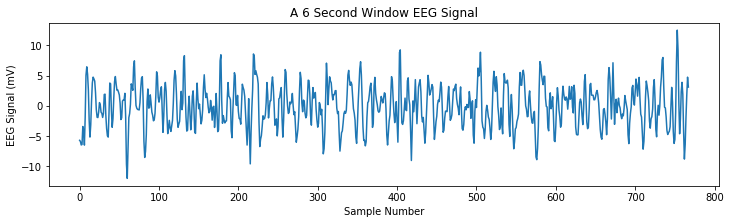

In [8]:
x = eeg_data[0,0,0,6,:] #test sample

plt.figure(figsize=(12,3))
plt.plot(x)
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");

In [29]:
#dictionary (D) we should be using is inverse db5 WT matrix
#seems like we want to use idwt from pywt with 'db5'

# y = Phi * D * z
# y is compressed data
# Phi is sensing matrix 
# D is inverse db5 WT matrix
# z is D_inv * x, where D_inv is the db5 WT matrix and x is the EEG signal. I think. 

#ok so what I'm understanding is we want to run CS on y = Az to recover z, where A is Phi.dot(D). Then we
#can recover x by doing the wavelet transform on z. 

#later when we want to do reconstruction-free CS, we want to just recover y and then do DWT on y, then apply
#ml algorithms

In [31]:
levels = 6

## Wavelet functions below
## Note: we expect all image sizes to be powers-of-two and square!
## So if you adapt this code, be sure to fix this or enforce this requirement...

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
    c = pywt.wavedec(np.zeros((n,)), 'db5', level=levels)
    bye, slices = pywt.coeffs_to_array(c)
    return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
    c = pywt.wavedec(sdom_data, 'db5', level=levels)
    output, slices = pywt.coeffs_to_array(c)
    return output, slices

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
    n = wdom_data.shape[0]
    if slices is None:
        slices = default_slices(levels, n)
    c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec')
    return pywt.waverec(c, 'db5')

def meas_map(mtx, Phi, slices=None):
    pre_proj = idwt(levels, mtx, slices)
    y = Phi.dot(pre_proj)
    return y

def meas_map_adj(mtx, Phi):
    mtx = mtx.dot(Phi)
    output, slices = dwt(levels, mtx)
    return output

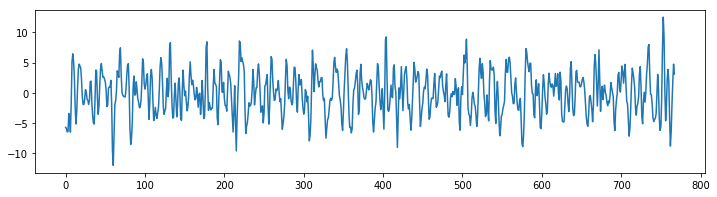

In [89]:
#check that dwt and idwt make sense here

forward, forward_slices = dwt(levels, x)
backward = idwt(levels, forward, forward_slices)

plt.figure(figsize=(12,3))
plt.plot(backward);

In [136]:
# 0.2

def complex_l1_prox(s, lam):
    phases = np.angle(s)
    mags = np.abs(s)
    thresholded = l1_prox_matrix(mags, lam)
    return thresholded * np.exp(1j * phases)

def l1_prox_matrix(s, lam):
    s = s.copy()
    for i in range(s.shape[0]):
        if s[i] > lam:
            s[i] -= lam
        elif s[i] < -1 * lam:
            s[i] += lam
        else:
            s[i] = 0
    return s

def prox_grad_desc(Phi, y, lam, slices, shape):

    s = np.random.normal(size = shape)
    scale = np.linalg.norm(s)
    s = s / scale
    
    s_prev = 0
    diff = np.linalg.norm(s - s_prev)
    alpha = 1 / (np.real(np.sort(np.linalg.eig(Phi.T.dot(Phi))[0])[-1]))

    count = 0
    while diff > 5E-6:
        s_grad = meas_map_adj((meas_map(s, Phi, slices) - y), Phi)
        s_new = s - alpha * s_grad
        s_new = complex_l1_prox(s_new, lam)

        s_prev = s
        s = s_new
        diff = np.linalg.norm(s - s_prev)

        if count % 10000 == 0:
            print(count, diff)
        count += 1
        
    return s

0.1
0 0.041240604295829375
10000 2.3676242560781138e-05
20000 1.9091031022091377e-05
30000 1.5071486325646526e-05
40000 1.0942772249497483e-05
50000 8.00208420928126e-06
60000 6.29019481072429e-06
70000 5.415818320592256e-06
Done
3.448937271716748
0.004470148003484627
149.47056731107725
96.05640382203308
0.2
0 0.03399989369645188
10000 2.4028537367306978e-05
20000 1.9989896228014953e-05
30000 1.695856657146082e-05
40000 1.3006030727994424e-05
50000 9.531777018039533e-06
60000 6.603786954388393e-06
Done
2.258420737773071
0.011776918985858292
149.6226480363838
96.05640382203308
0.3
0 0.02464597127724944
10000 2.4307442032334577e-05
20000 2.1205833855319206e-05
30000 1.799273022144634e-05
40000 1.3500521497680286e-05
50000 1.0208107688354339e-05
60000 6.966624322804256e-06
Done
1.7537685231316245
0.023988927495400235
149.71329951954752
96.05640382203308
0.4
0 0.016166654548078054
10000 2.4417360644067632e-05
20000 2.0609194871013005e-05
30000 1.8165658471899246e-05
40000 1.459512615097189

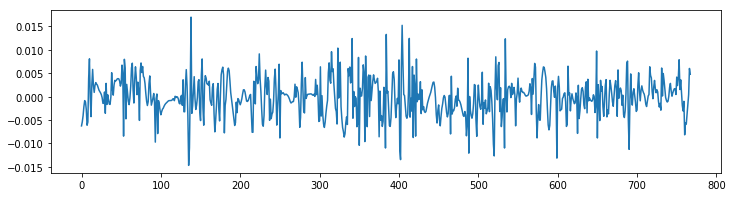

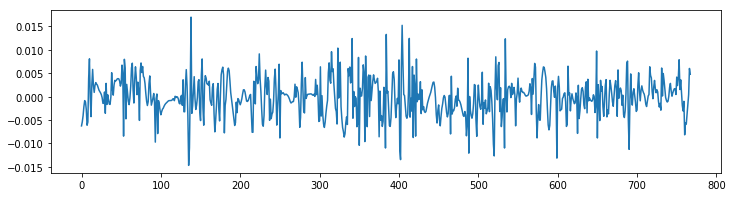

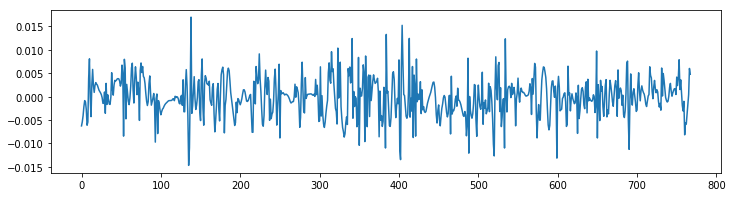

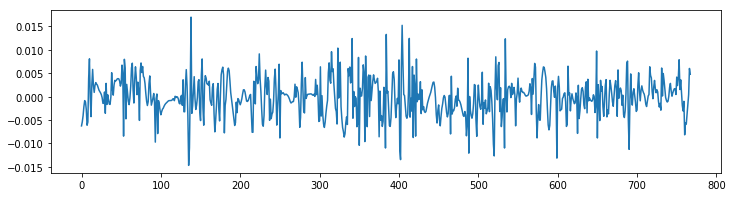

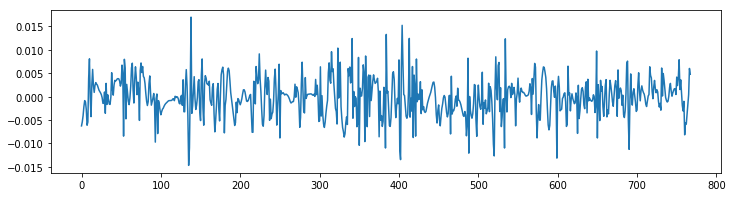

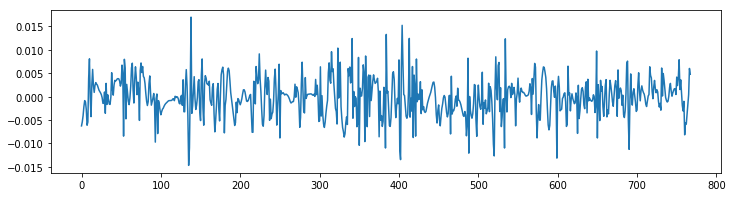

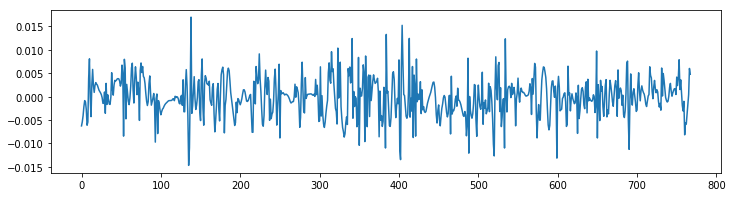

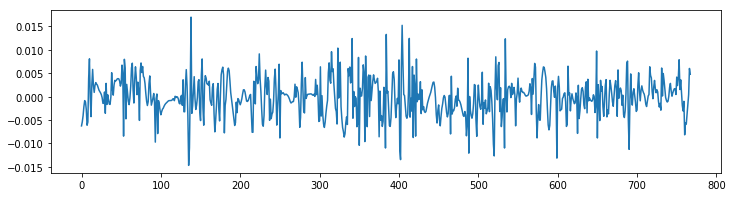

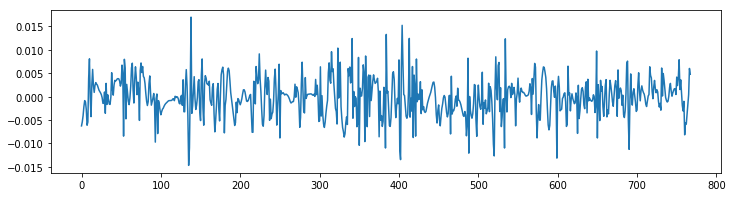

In [137]:
for p in [i / 10 for i in range(1,10)]:
    print(p)
    M = 192
    N = 768
#     p = 0.25

    Phi = np.random.binomial(1, p, size = (M,N))
    s, slices = dwt(levels, x)
    y = meas_map(s, Phi, slices)
    scale = np.linalg.norm(y)
    y = y / scale
    lam = 0.000001


    rec_s = prox_grad_desc(Phi, y, lam, slices, s.shape) 
    rec_x = np.real(idwt(levels, rec_S, slices))

    print("Done")
    print(np.linalg.norm(rec_s, ord = 1))
    print(np.linalg.norm(meas_map(rec_s, Phi, slices) - y, ord = 2))
    print(np.linalg.norm(rec_s - s))
    print(np.linalg.norm(rec_x - x))

    plt.figure(figsize=(12,3))
    plt.plot(rec_x);

## Different Attempt (Deprecated)

In [12]:
# 0.1
import numpy as np
np.random.seed(42)

def l1_prox(x, lam):
    for i in range(len(x)):
        if x[i] > lam:
            x[i] -= lam
        elif x[i] < -1 * lam:
            x[i] += lam
        else:
            x[i] = 0
    return x

def prox_grad_desc(A, y, lam):

    x = np.random.random((n,))
    x_prev = 0
    diff = np.linalg.norm(x - x_prev)
    alpha = 1 / (np.real(np.sort(np.linalg.eig(A.T.dot(A))[0])[-1]))

    while diff > 10E-10:
        x_grad = A.T.dot(A.dot(x) - y)
        x_new = x - alpha * x_grad
        x_new = l1_prox(x_new, lam)

        x_prev = x
        x = x_new

        diff = np.linalg.norm(x - x_prev)

    return x

In [15]:
n = 100
m = 50
k = 12
lam = 0.0001

x = np.array([1 for _ in range(k)] + [0 for _ in range(n - k)])
np.random.shuffle(x)
A = np.random.random((m,n))
y = A.dot(x)

x_rec = prox_grad_desc(A, y, lam)

print(np.linalg.norm(x_rec, ord = 1))
print(np.linalg.norm(A.dot(x_rec) - y, ord = 2))
print(np.linalg.norm(x_rec - x))

11.985114446539352
0.04337197462066658
0.02379389505243126


In [64]:
levels = 6
x = eeg_data[0,0,0,6,:] #test sample
s, slices = dwt(levels, x)

#compression (1/4 original size)
M = 192
N = 768

p = 15/M
Phi = np.random.binomial(1, p, size = (M,z.shape[0]))

# y = np.dot(Phi, x) #compressed data, y = Phi*x

In [80]:
#Trying to figure out how to generate a wavelet matrix
# https://www.ece.uvic.ca/~jyan/Publications/Technial%20Reports/wavelet%20matrix.pdf

levels = 6
I = np.eye(N,N)
W = np.zeros((817,817))

for i in range(N):
    d = I[:,i]
    w_i, slices = dwt(levels, d)
    W[:,i] = w_i

In [97]:
print(W.shape)
np.linalg.inv(W)

(817, 817)


LinAlgError: Singular matrix

In [91]:
#Trying to figure out how to generate inverse wavelet matrix

levels = 6
I = np.eye(817,817)
W_inv = np.zeros((N,N))

for i in range(N):
    d = I[:,i]
    w_inv_i = idwt(levels, d, slices)
    W_inv[:,i] = w_inv_i

In [92]:
print(W_inv.shape)
np.linalg.inv(W_inv) #can try just doing Phi * W_inv then and calling that A? shape of s will be an issue I think.
#Solve this and I think it will run?

(768, 768)

## Unsupervised Learning

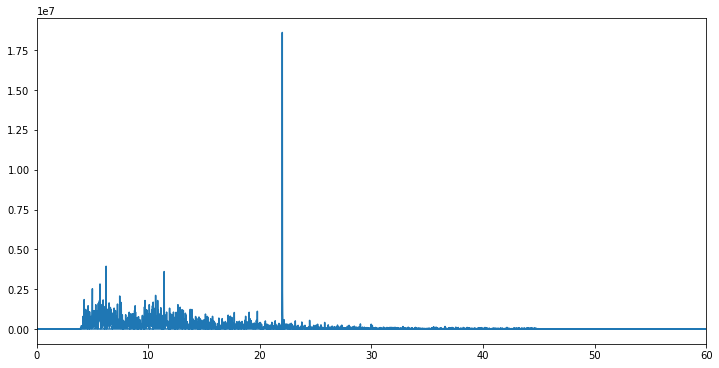

In [9]:
ps = np.abs(np.fft.fft(eeg_data[0,0,0,:]))**2
time_step = 1 / 128
freqs = np.fft.fftfreq(eeg_data[0,0,0,:].size, time_step)

plt.figure(figsize=(12,6))
plt.plot(freqs, ps);
plt.xlim([0,60]);

In [10]:
print(np.average(ps[(freqs >= 8) & (freqs <= 13)]))
print(np.average(ps[(freqs >= 14) & (freqs <= 30)]))
print(np.average(ps[(freqs >= 30) & (freqs <= 47)]))
print(np.average(ps[(freqs >= 4) & (freqs <= 7)]))

410777.0887284375
157972.96158821965
22409.773898126754
594068.9550429464


In [11]:
def calculate_frequency_band_powers(data):
    ps = np.log(np.abs(np.fft.fft(data))**2)
    time_step = 1 / 128
    freqs = np.fft.fftfreq(data.size, time_step)
    
    theta = np.average(ps[(freqs >= 4) & (freqs <= 7)])
    alpha = np.average(ps[(freqs >= 8) & (freqs <= 13)])
    beta = np.average(ps[(freqs >= 14) & (freqs <= 30)])
    gamma = np.average(ps[(freqs >= 30) & (freqs <= 47)])
    
    return [theta, alpha, beta, gamma]
    

def encode_feature_vector(data):
    feature_vector = []
    for channel in range(32):
        channel_data = data[channel,:]
        frequency_band_powers = calculate_frequency_band_powers(channel_data)
        feature_vector.extend(frequency_band_powers)

    left_channels = list(range(0,14))
    right_channels = [16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31]
    for left_channel,right_channel in zip(left_channels, right_channels):
        left_channel_powers = calculate_frequency_band_powers(data[left_channel,:])
        right_channel_powers = calculate_frequency_band_powers(data[right_channel,:])
        asymmetry_fn = lambda x,y: (x-y)/(x+y)
        aymmetries = [asymmetry_fn(rc,lc) for rc, lc in zip(right_channel_powers, left_channel_powers)]
        feature_vector.extend(aymmetries)
        
    return feature_vector

In [12]:
test_data = eeg_data[0,0,:,:]
feature_vector = encode_feature_vector(test_data)
len(feature_vector)

184

In [34]:
def calculate_differential_mean(x, order):
    shifted_x = np.roll(x, -order)[:-order]
    truncated_x = x[:-order]
    diff = truncated_x - shifted_x
    return np.mean(np.abs(diff))

def calculate_time_features(x):
    mean = np.mean(x)
    sd = np.std(x)
    d1 = calculate_differential_mean(x, 1)
    d2 = calculate_differential_mean(x, 2)
    return [mean, sd, d1, d2]

calculate_time_features(test_data[0])

[-0.029671511237175388,
 3.9085428321601783,
 2.2430354888176347,
 3.7771587082295075]

In [183]:
feature_matrix = np.zeros(shape = (1280, 184)) #32 individuals who watched 40 videos = 1280
labels_matrix = np.zeros(shape = (1280, 4)) #four labels are (valence, arousal, dominance, liking)
for indiv in range(32):
    for video in range(40):
        feature_matrix[(40 * indiv) + video,:] = encode_feature_vector(eeg_data[indiv, video,:,:])
        labels_matrix[(40 * indiv) + video,:] = labels[indiv,video,:]

In [179]:
kmeans = sklearn.cluster.KMeans(n_clusters=8, random_state=0).fit(feature_matrix)

In [180]:
counts = {}
for i in kmeans.labels_:
    if i not in counts.keys():
        counts[i] = 0
    counts[i] += 1

In [181]:
counts

{6: 129, 2: 114, 0: 484, 4: 41, 3: 164, 5: 268, 7: 40, 1: 40}

In [208]:
num_clusters = 9
kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=0).fit(feature_matrix)
for cluster in range(num_clusters):
    d = labels_matrix[kmeans.labels_ == cluster]
    print("avgs for cluster #{0} are {1}".format(cluster, np.average(d, axis = 0)))
    print("stds for cluster #{0} are {1}".format(cluster, np.std(d, axis = 0)))
    print("")

avgs for cluster #0 are [5.64412844 5.4890367  5.39862385 5.86197248]
stds for cluster #0 are [2.10859848 1.88828    2.03259041 2.20427863]

avgs for cluster #1 are [4.62390244 5.16731707 5.02536585 5.01195122]
stds for cluster #1 are [2.45752392 1.90494354 1.51910291 2.52285767]

avgs for cluster #2 are [4.53189873 5.10886076 4.56683544 5.03924051]
stds for cluster #2 are [2.22053539 1.87202252 2.0074794  1.96322505]

avgs for cluster #3 are [5.10180212 5.35837456 4.91219081 5.48349823]
stds for cluster #3 are [2.06721025 1.80477699 1.92977126 2.12768678]

avgs for cluster #4 are [5.62554622 4.60957983 6.75016807 6.01521008]
stds for cluster #4 are [2.18158246 2.54910147 1.99826437 2.35639514]

avgs for cluster #5 are [4.907    4.8535   6.175625 4.826625]
stds for cluster #5 are [2.35460209 2.34982345 1.90144474 2.76268933]

avgs for cluster #6 are [5.76097561 5.42829268 5.82121951 5.66682927]
stds for cluster #6 are [2.85141198 2.93319679 2.75663209 3.21408974]

avgs for cluster #7 a

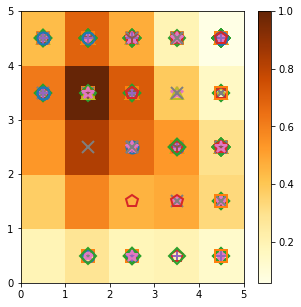

In [357]:
#Trying out SOM
som = MiniSom(5, 5, 184, sigma= 2.5, learning_rate=0.5, random_seed = 42) #would be helpful to set random generator
som.train(feature_matrix, 500)
target = np.round(labels_matrix[:,0])

plt.figure(figsize=(5, 5))

plt.pcolor(som.distance_map().T, cmap='YlOrBr')  # plotting the distance map as background
plt.colorbar();

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D', 'p', '+', '1', '*', 'x', '^']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'] #would need to round to make this work
label_names = dict(zip(list(range(1,10)), list(range(1,10))))
for cnt, xx in enumerate(feature_matrix):
    cnt = int(cnt)
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[int(target[cnt]-1)], markerfacecolor='None',
             markeredgecolor=colors[int(target[cnt]-1)], markersize=12, markeredgewidth=2)

plt.show()

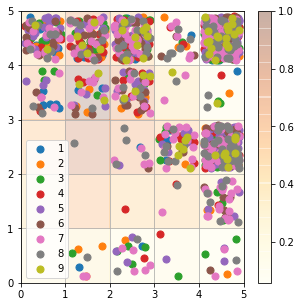

In [360]:
w_x, w_y = zip(*[som.winner(d) for d in feature_matrix])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(5, 5))
plt.pcolor(som.distance_map().T, cmap='YlOrBr', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    c = int(c)
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='lower left')
plt.grid()
plt.show()

## Supervised Learning

In [52]:
## Feature Extraction

def get_signal_statistics(x):
    mean = np.mean(x)
    median = np.median(x)
    maximum = np.max(x)
    minimum = np.min(x)
    std = np.std(x)
    var = np.var(x)
    data_range = maximum - minimum
    skewness = scipy.stats.skew(x)
    kurtosis = scipy.stats.kurtosis(x)
    return [mean, median, maximum, minimum, std, var, data_range, skewness, kurtosis]

def encode_feature_vector(signal, vol_num, exp_num):
    features = []
    chunk_size = signal.shape[0] // 10
    for i in range(10):
        start = i * chunk_size
        end = (i+1) * chunk_size if i < 9 else signal.shape[0]
        data_chunk = signal[start:end]
        chunk_features = get_signal_statistics(data_chunk)
        features.extend(chunk_features)
    signal_features = get_signal_statistics(signal)
    features.extend(signal_features)
    features.extend([vol_num, exp_num])
    return features
    

feature_vector = encode_feature_vector(data[0,0,0,:], 0, 0)
len(feature_vector)

101

In [142]:
## Define Data Matrix and labels

#the paper seems slighty suspect, like they don't even remove the three second baseline?
supervised_data = np.zeros(shape = (1280,4040), dtype = np.float32)
supervised_labels = np.zeros(shape = (1280,), dtype = np.float32)

for vol_num in range(32):
    print(vol_num)
    for exp_num in range(40):
        vec = []
        for chan_num in range(40):
            features = encode_feature_vector(data[vol_num, exp_num, chan_num,:], vol_num, exp_num)
            vec.extend(features)
        idx = (vol_num * 40) + exp_num
        supervised_data[idx] = vec
        supervised_labels[idx] = int(labels[vol_num, exp_num, 0] >= 5) #the paper had 5 as the threshold

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [205]:
## Save Data
with open("./supervised_data.npy", "wb") as f:
    np.save(f, supervised_data)
    
with open("./supervised_labels.npy", "wb") as f:
    np.save(f, supervised_labels)    

In [92]:
## Linear Model

class LinearEEGModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        hidden_dims = [5000, 500, 1000]
        dropout_probs = [0.25, 0.5, 0.5]
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.drop1 = nn.Dropout(dropout_probs[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.drop2 = nn.Dropout(dropout_probs[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.drop3 = nn.Dropout(dropout_probs[2])
        
        self.head = nn.Linear(hidden_dims[-1], output_dim) #still need to add sigmoid
        
    def forward(self, x):
        
        h1 = self.drop1(F.relu(self.fc1(x)))
        h2 = self.drop2(F.relu(self.fc2(h1)))
        h3 = self.drop3(F.relu(self.fc3(h2)))
        out = torch.sigmoid(self.head(h3))
        return out

In [ ]:
## Conv Model

In [202]:
## Training

batch_size = 310
num_epochs = 250

feature_dim = supervised_data.shape[1]
output_dim = 2
model = LinearEEGModel(feature_dim, output_dim)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)
criterion = nn.CrossEntropyLoss()
total = 0

for i in range(32):
    print(i)
    val_start_idx = i * 40 
    val_end_idx = (i+1) * 40
    val_data = torch.from_numpy(supervised_data[val_start_idx:val_end_idx])
    val_labels = torch.from_numpy(supervised_labels[val_start_idx:val_end_idx]).type(torch.LongTensor)
    train_data = np.concatenate((supervised_data[:val_start_idx], supervised_data[val_end_idx:]))
    train_labels = np.concatenate((supervised_labels[:val_start_idx], supervised_labels[val_end_idx:]))
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        shuffled_idxs = np.random.shuffle(np.arange(train_data.shape[0]))
        train_data = train_data[shuffled_idxs].squeeze()
        train_labels = train_labels[shuffled_idxs].squeeze()
        num_batches = math.ceil(train_data.shape[0] / batch_size)
        for batch_num in range(num_batches):
            batch_start_idx = batch_num * batch_size
            batch_end_idx = (batch_num + 1) * batch_size
            batch = torch.from_numpy(train_data[batch_start_idx:batch_end_idx])
            batch_labels = torch.from_numpy(train_labels[batch_start_idx:batch_end_idx]).type(torch.LongTensor)
            
            optimizer.zero_grad()
            outputs = model(batch)
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        model.eval()
        outputs = model(val_data)
        output_labels = torch.argmax(outputs, dim = 1)
        loss = criterion(outputs, val_labels)
        accuracy = (torch.sum(torch.eq(output_labels, val_labels)) / output_labels.shape[0]).item()
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
        
        if epoch % 50 == 0:
            print("Best Accuracy for subject {0} at epoch {1} is {2}%".format(i, epoch, best_accuracy))
            
    total += best_accuracy
            
print("Total accuracy is {0}%".format(total/32))
        

0
Best Accuracy for subject 0 at epoch 0 is 0.44999998807907104%
Best Accuracy for subject 0 at epoch 50 is 0.4749999940395355%
Best Accuracy for subject 0 at epoch 100 is 0.4749999940395355%
Best Accuracy for subject 0 at epoch 150 is 0.4749999940395355%
Best Accuracy for subject 0 at epoch 200 is 0.4749999940395355%
1
Best Accuracy for subject 1 at epoch 0 is 0.625%
Best Accuracy for subject 1 at epoch 50 is 0.625%
Best Accuracy for subject 1 at epoch 100 is 0.675000011920929%
Best Accuracy for subject 1 at epoch 150 is 0.675000011920929%
Best Accuracy for subject 1 at epoch 200 is 0.675000011920929%
2
Best Accuracy for subject 2 at epoch 0 is 0.550000011920929%
Best Accuracy for subject 2 at epoch 50 is 0.625%
Best Accuracy for subject 2 at epoch 100 is 0.625%
Best Accuracy for subject 2 at epoch 150 is 0.625%
Best Accuracy for subject 2 at epoch 200 is 0.625%
3
Best Accuracy for subject 3 at epoch 0 is 0.4000000059604645%
Best Accuracy for subject 3 at epoch 50 is 0.400000005960464

KeyboardInterrupt: 